In [1]:
%matplotlib inline
#import matplotlib
#matplotlib.use('tkAgg')
import matplotlib.pyplot as plt
import sys
import math
import numpy as np
import scipy as sp
import scipy.optimize
import scipy.misc
import scipy.special

In [2]:
EUR_DECIMALS = 10**18
NMK_DECIMALS = 10**18
CAP = 15 * 10**8
S = -6.5

In [3]:
def issued(cummulative_euros):
    return np.floor((- np.expm1(S * cummulative_euros / EUR_DECIMALS / CAP) ) * NMK_DECIMALS * CAP)

def frac(cummulative_euros):
    return issued(cummulative_euros) / issued(CAP)

def issuance(cummulative_euros):
    return - S * NMK_DECIMALS / EUR_DECIMALS * np.exp(S * cummulative_euros / EUR_DECIMALS / CAP)

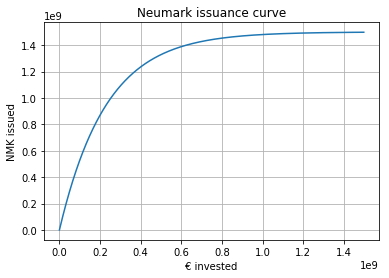

In [6]:
e = np.arange(0.0, 1.0 * CAP, 1.0 * CAP / 1000 )
n = issued(e * EUR_DECIMALS) / NMK_DECIMALS
plt.plot(e, n)

plt.xlabel('€ invested')
plt.ylabel('NMK issued')
plt.title('Neumark issuance curve')
plt.grid(True)
plt.savefig("Issued.png")
plt.show()

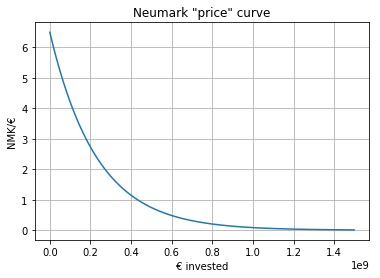

In [7]:
e = np.arange(0.0, 1.0 * CAP, 1.0 * CAP / 10**3)
n = issuance(e * EUR_DECIMALS) 
plt.plot(e, n)

plt.xlabel('€ invested')
plt.ylabel('NMK/€')
plt.title('Neumark "price" curve')
plt.grid(True)
plt.savefig("Issuance.png")
plt.show()

In [389]:
issuance(5 * 10**9 * EUR_DECIMALS)

2.5304606143628922e-09

In [198]:
def ref_exp(k, n, d, e):
    '''Computes k · (1 - n / d)^e '''
    return k * (1 - n / d) ** e

def binomial_exp(k, n, d, e):
    '''Computes k · (1 - n / d)^e '''
    # https://ethereum.stackexchange.com/questions/10425/is-there-any-efficient-way-to-compute-the-exponentiation-of-a-fraction-and-an-in/10432
    s = 0
    N = 1
    B = 1 # Binomial coefficient
    for i in range(22):
        
        s += k * (N / B) * (-1)**i * ((n ** i) / (d ** i))
        
        # Update binomial fraction
        N = N * (e - i)
        B = B * (i + 1)
    
    return s

In [324]:
def nChoose(n):
    k = 0
    N = 1
    yield 1
    while k < n:
        N *= (n - k)
        k += 1
        N = N // k
        yield N

In [325]:
[x for x in nChoose(10)]

[1, 10, 45, 120, 210, 252, 210, 120, 45, 10, 1]

In [553]:
A = 1 - np.exp(S * EUR_DECIMALS / CAP)
D = 2**54
N = int(np.round(A * D))

# Mathematica: round[ (1 - exp[ -65 / (15 * 10^9 * 10^18)  ]) * 2^64  ]
D = 2**64
N = 0

# Mathematica: round[ (1 - exp[ -65 / (15 * 10^9 * 10^18)  ]) * 2^96  ]
#D = 2**96
#N = 343

# Mathematica: round[ (1 - exp[ -65 / (15 * 10^9 * 10^18)  ]) * 2^128  ]
# F = 1
# D = 2**128
# N = 1474556923324

# Mathematica: round[ (1 - exp[ -65 * 2^9 / (15 * 10^9 * 10^18)  ]) * 2^128  ]
# F = 2**9
# D = 2**128
# N = 754973144741922

# Mathematica: round[ (1 - exp[ -65 * 2^18 / (15 * 10^9 * 10^18)  ]) * 2^128  ]
F = 2**18
D = 2**128
N = 386546250107864134

# Mathematica: round[ (1 - exp[ -65 * 2^32 / (15 * 10^9 * 10^18)  ]) * 2^128  ]
#F = 2**32
#D = 2**128
#N = 6333173761767245919948

# Mathematica: round[ (1 - exp[ -65 * 2^64 / (15 * 10^9 * 10^18)  ]) * 2^128  ]
# F = 2**64
# D = 2**128
# N = 27200773099516585549495154777920

# Mathematica: round[ (1 - exp[ -65 * 2^0 / (15 * 10^9 * 10^18)  ]) * 2^256  ]
# F = 2**0
# D = 2**256
# N = 501765720028370180168807600617155207302701209852026

# Mathematica: Rationalize[ (1 - exp[ -65 * 2^18 / (15 * 10^9 * 10^18)  ]), 2^-140 ]
F = 2**18
D = 880314753605769230770
N = 1

# Mathematica: Round[1 / (1 - exp[ -65 * 2^0 / (15 * 10^9 * 10^18)  ])]
F = 2**0
D = 230769230769230769230769231
N = 1

check = True
debug = True
def opt_exp_old(k, n, d, e):
    '''Computes k - k · (1 - 1 / d)^e '''
    global debug, check
    i = 0
    N = k
    s = 0
    e += F // 2
    e = e // F
    while N > 0:
        N *= e - i
        if check:
            assert(N < 2**256)
        i += 1
        N = N // i
        N *= n
        if check:
            assert(N < 2**256)
        N = N // d
        s += N
        if debug:
            print(N)
        if N == 0:
            break
        N *= e - i
        if check:
            assert(N < 2**256)
        i += 1
        N = N // i
        N *= n
        if check:
            assert(N < 2**256)
        N = N // d
        s -= N
        if debug:
            print(N)
    return s

def opt_exp(k, d, e):
    '''Computes k - k · (1 - 1 / d)^e '''
    global debug, check
    i = 0
    N = k
    s = 0
    D = d
    while N > 0:
        N *= e
        if check:
            assert(N < 2**256)
            assert(D < 2**256)
            assert(e >= 0)
        N = N // D
        if debug:
            print(N)
        if N == 0:
            break
        s += N
        # e -= 1
        D += d
        
        N *= e
        if check:
            assert(D < 2**256)
            assert(N < 2**256)
            assert(e >= 0)
        N = N // D
        if debug:
            print(N)
        if N == 0:
            break
        s -= N
        # e -= 1
        D += d
    return s

L = 83
def implementation(x):
    x = int(x)
    if x >= L * 10**8 * EUR_DECIMALS:
        return CAP * NMK_DECIMALS
    my = opt_exp(CAP * NMK_DECIMALS, D, x)
    return my

In [554]:
implementation(1) / NMK_DECIMALS

6
0


6e-18

In [555]:
L * 10**8 * EUR_DECIMALS

8300000000000000000000000000

In [556]:
implementation(L * 10**8 * EUR_DECIMALS) / NMK_DECIMALS

1500000000.0

In [557]:
issued(L * 10**8 * EUR_DECIMALS) / NMK_DECIMALS

1499999999.9999995

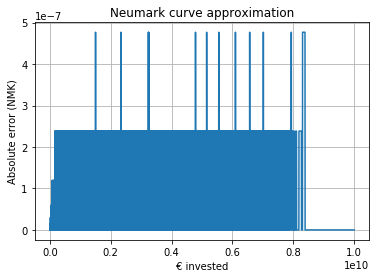

In [558]:
debug = False
e = np.arange(0.0, 10.0 * 10**9, 10**6)
i = np.array([implementation(x * EUR_DECIMALS) for x in e]) / NMK_DECIMALS
a = issued(e * EUR_DECIMALS) / NMK_DECIMALS
n = np.abs(i - a)
plt.plot(e, n)

plt.xlabel('€ invested')
plt.ylabel('Absolute error (NMK)')
plt.title('Neumark curve approximation')
plt.grid(True)
plt.savefig("Issuance.png")
plt.show()

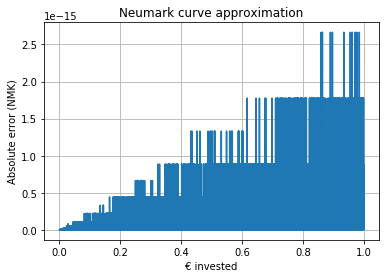

In [559]:
debug = False
e = np.arange(0.0, 1.0, 0.0001)
i = np.array([implementation(x * EUR_DECIMALS) for x in e]) / NMK_DECIMALS
a = issued(e * EUR_DECIMALS) / NMK_DECIMALS
n = np.abs(i - a)
plt.plot(e, n)

plt.xlabel('€ invested')
plt.ylabel('Absolute error (NMK)')
plt.title('Neumark curve approximation')
plt.grid(True)
plt.savefig("Issuance.png")
plt.show()

In [532]:
implementation(0)

0

In [502]:
previous = 0
for x in range(10**4):
    new = implementation(x)
    assert(new >= previous)
    previous = new

In [26]:
implementation(10**8)/implementation(CAP)

0.06666666665297862

In [27]:
implementation(135000001)

876676907

In [28]:
np.floor(issued(135000001))

877500006.0

In [29]:
664341210 # Wolfram alpha

664341210

In [30]:
N

343

In [31]:
78062393

78062393

In [32]:
S

-6.5

In [33]:
S/CAP

-4.333333333333333e-09

In [34]:
CAP

1500000000

In [35]:
[int(x) for x in 
issued(np.array(range(10)))]

[0, 6, 13, 19, 26, 32, 39, 45, 52, 58]

In [36]:
implementation(2)

12

In [37]:
[[x, int(issued(x))] for x in range(0, 10**1, 10**0)]

[[0, 0],
 [1, 6],
 [2, 13],
 [3, 19],
 [4, 26],
 [5, 32],
 [6, 39],
 [7, 45],
 [8, 52],
 [9, 58]]